In [14]:
from pathlib import Path
import tarfile


import matplotlib.pyplot as plt
%matplotlib notebook

from threeML import download_GBM_trigger_data, download_GBM_daily_data

import gbmgeometry
from gbmgeometry.io.data_download import download_posthist, download_trigdat, get_official_location

gbm_detectors = [f"n{x}" for x in range(10)]
gbm_detectors.extend(['na','nb','b0','b1'])


import gbm_drm_gen




# Setup the variables

## Type of data

### Trigger data

In [2]:
grb_trigger_number = "bn080916009"

# do not alter
using_daily_data = False

In [10]:
download_trigdat(grb_trigger_number)
spacecraft_file = list(Path('.').glob(f'trigdat_{grb_trigger_number}_v*.h5'))[0]

gbm_data = download_GBM_trigger_data(grb_trigger_number, cspec_only=True)

for k,v in gbm_data.items():
    
    Path(v['rsp']).unlink()
    
    v.pop('rsp')

The data have been downloaded to ./trigdat_bn080916009_v02.h5
[INFO    ] file glg_cspec_n0_bn080916009_v01.pha is already downloaded!


[INFO    ] file glg_cspec_n1_bn080916009_v01.pha is already downloaded!


[INFO    ] file glg_cspec_n2_bn080916009_v01.pha is already downloaded!


[INFO    ] file glg_cspec_n3_bn080916009_v01.pha is already downloaded!


[INFO    ] file glg_cspec_n4_bn080916009_v01.pha is already downloaded!


[INFO    ] file glg_cspec_n5_bn080916009_v01.pha is already downloaded!


[INFO    ] file glg_cspec_n6_bn080916009_v01.pha is already downloaded!


[INFO    ] file glg_cspec_n7_bn080916009_v01.pha is already downloaded!


[INFO    ] file glg_cspec_n8_bn080916009_v01.pha is already downloaded!


[INFO    ] file glg_cspec_n9_bn080916009_v01.pha is already downloaded!


[INFO    ] file glg_cspec_na_bn080916009_v01.pha is already downloaded!


[INFO    ] file glg_cspec_nb_bn080916009_v01.pha is already downloaded!


[INFO    ] file glg_cspec_b0_bn080916009_v01.pha is already downloaded!


[INFO    ] file glg_cspec_b1_bn080916009_v01.pha is already downloaded!


### Daily data

In [2]:
#year
year = '20'
month = '01'
day = '16'

# MET to zero the daily data
# Use None if you do not want to zero
T0 = 600835545.0

using_daily_data = True

In [3]:
download_posthist(year, month, day)
spacecraft_file = f"poshist_{year}{month}{day}.h5"


gbm_data = download_GBM_daily_data(year, month, day, cspec_only=True)

The data have been downloaded to ./poshist_200116.h5


## Sky location

### Official location

In [56]:
ra, dec, loc_err = get_official_location(grb_trigger_number)
print(ra, dec, loc_err)

119.8 -56.6 0.0


### Custom location

In [4]:
ra = 10.
dec = 10

# Examine geometry

In [55]:
if using_daily_data:
    
    position_interpolator = gbmgeometry.PositionInterpolator.from_poshist_hdf5(spacecraft_file, T0=T0)

else:
    
    position_interpolator = gbmgeometry.PositionInterpolator.from_trigdat_hdf5(spacecraft_file)


<IPython.core.display.Javascript object>


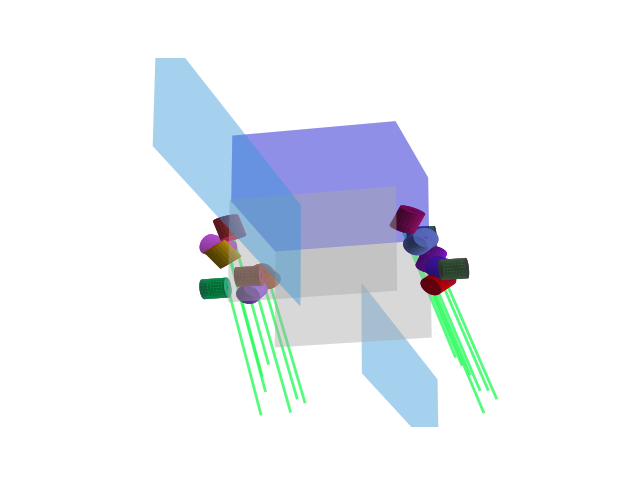

In [57]:
from gbmgeometry.spacecraft.fermi import *
from astropy.coordinates import SkyCoord

coord = SkyCoord(ra=ra,dec=dec, unit='deg', frame='icrs')



fermi = Fermi(quaternion=position_interpolator.quaternion(0) , sc_pos=position_interpolator.sc_pos(0))

fermi.add_ray(ray_coordinate=coord)

fermi.plot_fermi(color_dets_different=True, 
                 plot_det_label=False,
                 with_intersections=True, 
                 with_rays=True);

# Generate Responses

## Single Epoch Response

In [22]:
with tarfile.open("output.tar", "w") as tar:
    for detector in gbm_detectors[:1]:

        if using_daily_data:

            drm_generator = gbm_drm_gen.DRMGen.from_128_bin_data(det_name= detector,
                                                                 T0=T0,
                                                                 time=0, # time relative to T0 or trigger time.
                                                                 poshist = spacecraft_file,
                                                                 mat_type = 2, # direct response + atmospheric scattering
                                                                 cspecfile = gbm_data[detector]['cspec'])
            
            stub = f"bn{year}{month}{day}"
            
            

        else:

            drm_generator = gbm_drm_gen.DRMGen.from_128_bin_data(det_name= detector,
                                                     time=0, # time relative to T0 or trigger time.
                                                     trigdat = spacecraft_file,
                                                     mat_type = 2, # direct response + atmospheric scattering
                                                     cspecfile = gbm_data[detector]['cspec'])
            
            stub = f"{grb_trigger_number}"


        
        file_name = f"{stub}_{detector}.rsp"
        
        drm_generator.to_fits(ra=ra, dec=dec, filename=f"{stub}", overwrite=True)
        
        tar.add(file_name)

# clean up
_ =[x.unlink() for x in Path('.').glob('*.rsp')]


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.525152206420898)



In [24]:
!open .

## Time resolved response (RSP2)

### Define the times

Now define the time range for the RSP2s to be valid. This assumes you specified a `T0` in MET if you are using daily data.
Times are relative to T0 or the GRB trigger time. 

In [27]:
tstart = 0
tstop = 10
delta_time = 2 # the time spacing between intervals

### Produce the responses

In [28]:

with tarfile.open("output.tar", "w") as tar:
    

    for detector in gbm_detectors[:1]:

        if using_daily_data:

            drm_generator = gbm_drm_gen.DRMGen.from_128_bin_data(det_name= detector,
                                                                 T0=T0,
                                                                 time=0, # time relative to T0 or trigger time.
                                                                 poshist = spacecraft_file,
                                                                 mat_type = 2, # direct response + atmospheric scattering
                                                                 cspecfile = gbm_data[detector]['cspec'])
            
            stub = f"bn{year}{month}{day}"

        else:

            drm_generator = gbm_drm_gen.DRMGen.from_128_bin_data(det_name= detector,
                                                     time=0, # time relative to T0 or trigger time.
                                                     trigdat = spacecraft_file,
                                                     mat_type = 2, # direct response + atmospheric scattering
                                                     cspecfile = gbm_data[detector]['cspec'])
            
            stub = f"{grb_trigger_number}"

        file_name = f"{stub}_{detector}.rsp2"

        gbm_drm_gen.create_rsp2(file_name,
                                response_generator=drm_generator,
                                ra=ra,
                                dec=dec,
                                tstart=tstart,
                                tstop=tstop,
                                delta_time=delta_time,
                                overwrite=True
               )

        tar.add(file_name)
    


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.525152206420898)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.525152206420898)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.525152206420898)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.525152206420898)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.525152206420898)



# Download the files

Now just simply download the files by
